In [1]:
! pip install yfinance

     |████████████████████████████████| 4.7 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.9 MB 14.0 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.5
    Uninstalling pandas-1.2.5:
      Successfully uninstalled pandas-1.2.5
  Attempting uninstall: lxml
    Found existing installation: lxml 4.7.1
    Uninstalling lxml-4.7.1:
      Successfully uninstalled lxml-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stock_apple = yf.download('AAPL', start='2018-01-01', end='2021-12-01')
stock_amazon = yf.download('AMZN', start='2018-01-01', end='2021-12-01')
stock_microsoft = yf.download('MSFT', start='2018-01-01', end='2021-12-01')
stock_google = yf.download('GOOG', start='2018-01-01', end='2021-12-01')
# stock_tesla = yf.download('TSLA', start='2018-01-01', end='2021-12-01')
stock_apple.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133545,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447342,82271200


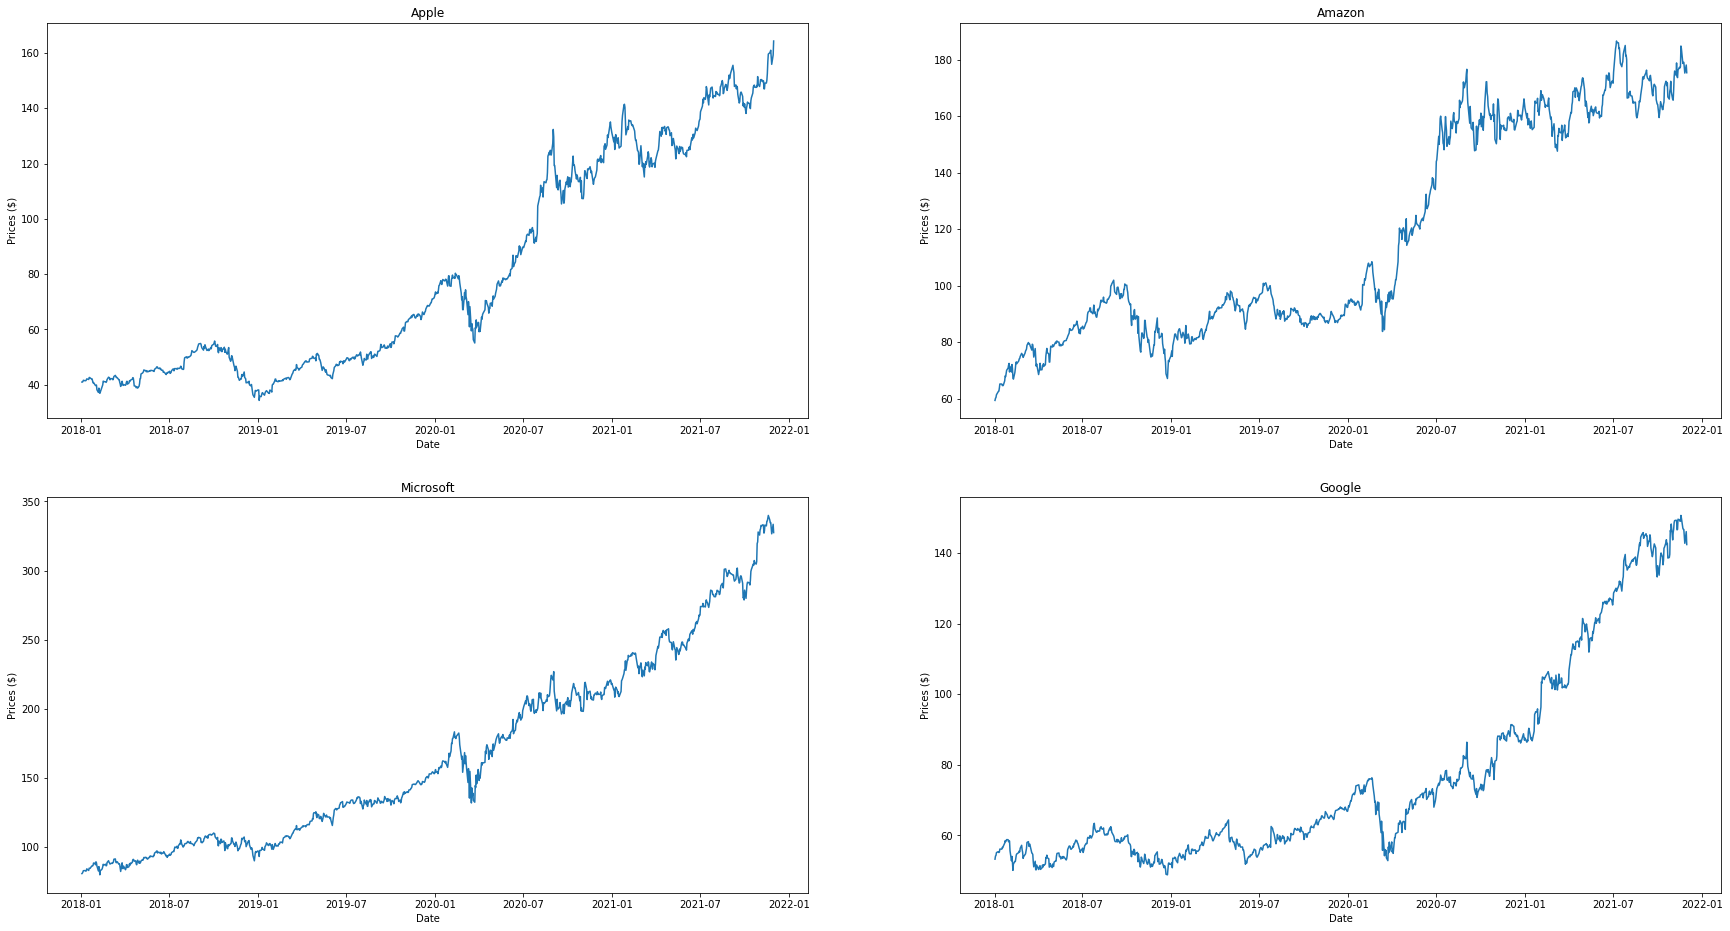

In [4]:
close_prices = [ stock_apple['Adj Close'], stock_amazon['Adj Close'], stock_microsoft['Adj Close'], stock_google['Adj Close'] ]

fig, ax = plt.subplots(2, 2, figsize=(30, 16))
ax[0, 0].plot(close_prices[0], label='Apple')
ax[0, 1].plot(close_prices[1], label='Amazon')
ax[1, 0].plot(close_prices[2], label='Microsoft')
ax[1, 1].plot(close_prices[3], label='Google')

ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Prices ($)')
ax[0, 0].set_title("Apple")

ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Prices ($)')
ax[0, 1].set_title("Amazon")

ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Prices ($)')
ax[1, 0].set_title("Microsoft")

ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Prices ($)')
ax[1, 1].set_title("Google")
plt.show()

In [5]:
sequence_length = 240
values = close_prices[0].values
training_data_len = int(len(values)* 0.8)

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
x_train[0:5]

array([[[0.05106953],
        [0.0510147 ],
        [0.05247722],
        ...,
        [0.04906165],
        [0.04993374],
        [0.05336656]],

       [[0.0510147 ],
        [0.05247722],
        [0.05607863],
        ...,
        [0.04993374],
        [0.05336656],
        [0.04321654]],

       [[0.05247722],
        [0.05607863],
        [0.05489037],
        ...,
        [0.05336656],
        [0.04321654],
        [0.04035902]],

       [[0.05607863],
        [0.05489037],
        [0.05485379],
        ...,
        [0.04321654],
        [0.04035902],
        [0.04431138]],

       [[0.05489037],
        [0.05485379],
        [0.05478068],
        ...,
        [0.04035902],
        [0.04431138],
        [0.0346994 ]]])

In [14]:
test_data = scaled_data[training_data_len-sequence_length: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(sequence_length, len(test_data)):
  x_test.append(test_data[i-sequence_length:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
548/548 [==============================] - 87s 154ms/step - loss: 0.0038
Epoch 2/3
548/548 [==============================] - 75s 136ms/step - loss: 0.0011
Epoch 3/3
548/548 [==============================] - 78s 142ms/step - loss: 9.8104e-04


In [19]:
test_data = scaled_data[training_data_len-sequence_length: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(sequence_length, len(test_data)):
  x_test.append(test_data[i-sequence_length:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

7/7 [==============================] - 2s 100ms/step
6.91589602075442


<ipython-input-22-d95227ab613b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


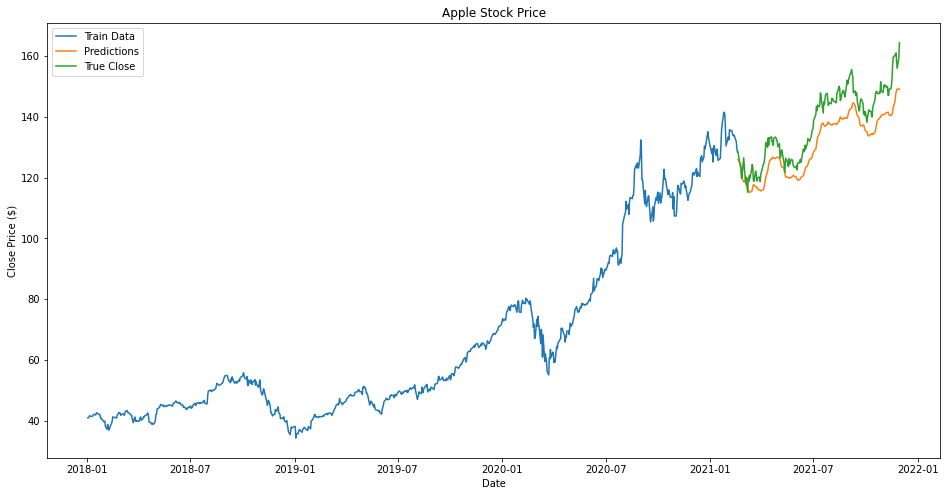

In [22]:
data = stock_apple.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train)
plt.plot(validation[['Predictions', 'Adj Close' ]])
plt.legend(['Train Data', 'Predictions', 'True Close' ], loc='upper left')
plt.show()